[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andyx\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\andyx\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andyx\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


----------- QUESTION 1 -----------


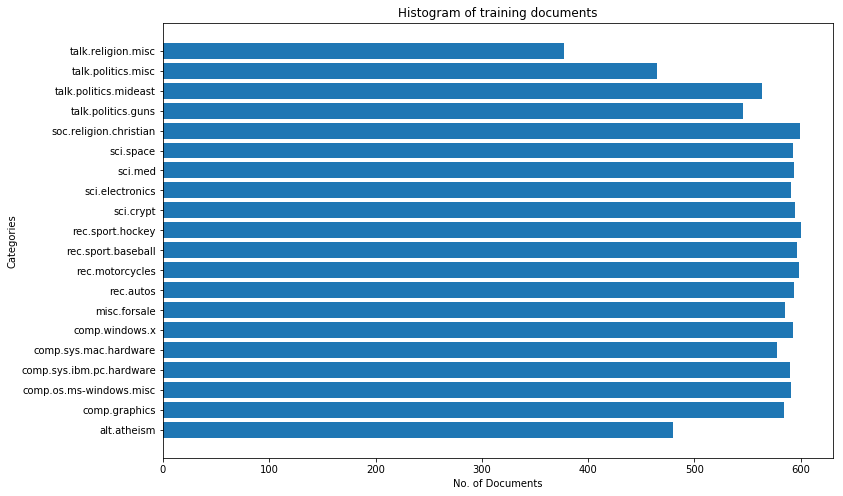

In [17]:
# -*- coding: utf-8 -*-

import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction import text
from nltk import pos_tag
from nltk.corpus import stopwords
from string import punctuation
from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import itertools
plt.rcParams['figure.figsize'] = [12, 8]  #set image size for display

"""
QUESTION 1
"""
print("----------- QUESTION 1 -----------")

newsgroups_train = fetch_20newsgroups(subset='train')
cat_Ndocs = {}
for i in newsgroups_train.target_names:
		training_data = fetch_20newsgroups(subset='train', categories=[i])
		cat_Ndocs[i] = len(training_data.data)

fig,ax = plt.subplots()
plt.barh(list(newsgroups_train.target_names), list(cat_Ndocs.values()))
#labels = ax.get_yticklabels()
#plt.setp(labels, rotation=20, fontsize=10)
plt.xlabel('No. of Documents')
plt.ylabel('Categories')
plt.title('Histogram of training documents')
plt.show()

In [18]:
"""
QUESTION 2
"""
print("----------- QUESTION 2 -----------")

categories = ['comp.graphics', 'comp.os.ms-windows.misc',
'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
'rec.autos', 'rec.motorcycles',
'rec.sport.baseball', 'rec.sport.hockey']
train_dataset = fetch_20newsgroups(subset = 'train', categories = categories, 
                                   shuffle = True, random_state = 42)
test_dataset = fetch_20newsgroups(subset = 'test', categories = categories, 
                                  shuffle = True, random_state = 42)

stop_words_skt = text.ENGLISH_STOP_WORDS
stop_words_en = stopwords.words('english')
combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))

#  Converts Penn Treebank tags to WordNet.
def penn2morphy(penntag):
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

    
wnl = nltk.wordnet.WordNetLemmatizer()    

def lemmatize_sent(list_word):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) for word, tag in pos_tag(list_word)]

def stem_rmv_punc(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if word not in combined_stopwords and not word.isdigit())

analyzer = text.CountVectorizer().build_analyzer()

# Remove stopword, number and set min_df = 3
vectorizer = text.CountVectorizer(min_df=3, stop_words='english', analyzer=stem_rmv_punc, token_pattern = r'(?u)\b[A-Za-z][A-Za-z]+\b')

# For the train data
X_train_counts = vectorizer.fit_transform(train_dataset.data)
X_train_counts.toarray()

# For the test data
X_test_counts = vectorizer.transform(test_dataset.data)
X_test_counts.toarray()

# The following is the tfidf part
# For the train data
X_train_tfidf = text.TfidfTransformer().fit_transform(X_train_counts)
print('Shape of TF-IDF train matrices subset: ')
print(X_train_tfidf.shape)

# For the test data
X_test_tfidf = text.TfidfTransformer().fit_transform(X_test_counts)
print('Shape of TF-IDF test matrices subset: ')
print(X_test_tfidf.shape)



----------- QUESTION 2 -----------
Shape of TF-IDF train matrices subset: 
(4732, 16292)
Shape of TF-IDF test matrices subset: 
(3150, 16292)


In [19]:
"""
QUESTION 3
"""

print("----------- QUESTION 3 -----------")
# LSI dimensionality reduction
lsi = TruncatedSVD(n_components=50, random_state=42) 
X_train_LSI = lsi.fit_transform(X_train_tfidf)
X_test_LSI = lsi.transform(X_test_tfidf)
print(X_train_LSI.shape)
print(X_test_LSI.shape)


# NMF dimensionality reduction
nmf = NMF(n_components=50, random_state=42)
X_train_NMF = nmf.fit_transform(X_train_tfidf)
X_test_NMF = nmf.transform(X_test_tfidf)
print(X_train_NMF.shape)
print(X_test_NMF.shape)

# compare LSI & NMF
# for NMF
H = nmf.components_
sum_train_NMF = np.sum(np.square(X_train_tfidf - X_train_NMF.dot(H)))
sum_test_NMF = np.sum(np.square(X_test_tfidf - X_test_NMF.dot(H)))
print(sum_train_NMF)
print(sum_test_NMF)

# for LSI
VT = lsi.components_
sum_train_LSI = np.sum(np.square(X_train_tfidf - X_train_LSI.dot(VT)))
sum_test_LSI = np.sum(np.square(X_test_tfidf - X_test_LSI.dot(VT)))
print(sum_train_LSI)
print(sum_test_LSI)

----------- QUESTION 3 -----------
(4732, 50)
(3150, 50)
(4732, 50)
(3150, 50)
4142.63740537972
2838.3214283816583
4107.971183106478
2827.9927076044114


----------- QUESTION 4 -----------

Hard Margin ----------------------------
Confusion Matrix: 

C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Normalized confusion matrix
[[0.97 0.03]
 [0.03 0.97]]
Confusion matrix, without normalization
[[1515   45]
 [  42 1548]]


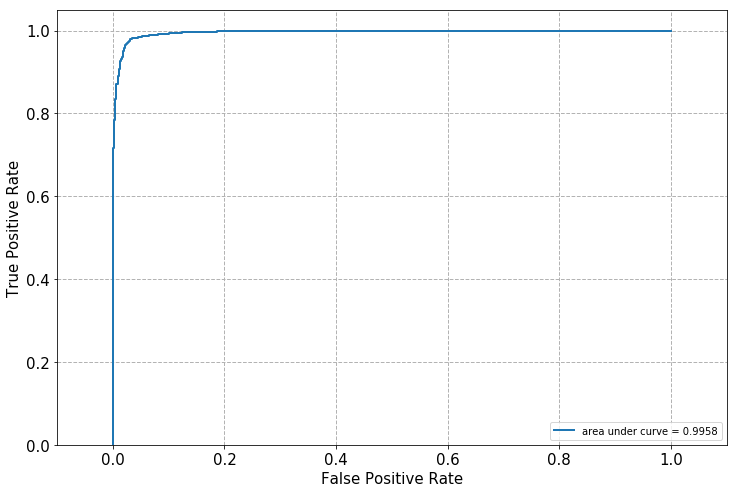

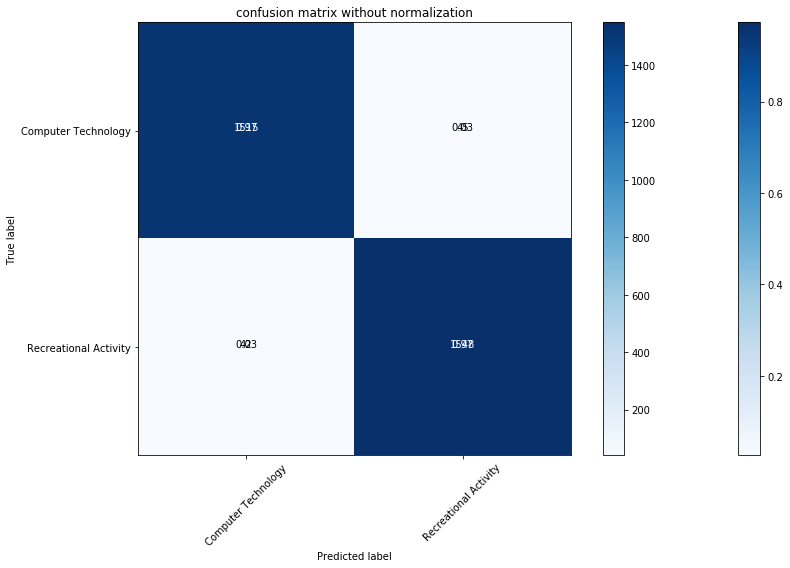

Accuracy: 0.9723809523809523
Recall: 0.9735849056603774
Precision: 0.9717514124293786
F1-Score: 0.9726672950047125

Soft Margin ----------------------------
Confusion Matrix: 
Normalized confusion matrix
[[0.35 0.65]
 [0.   1.  ]]
Confusion matrix, without normalization
[[ 540 1020]
 [   0 1590]]


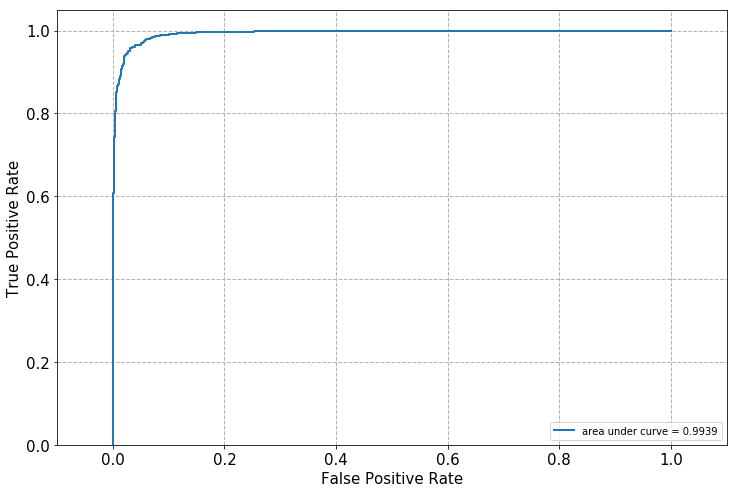

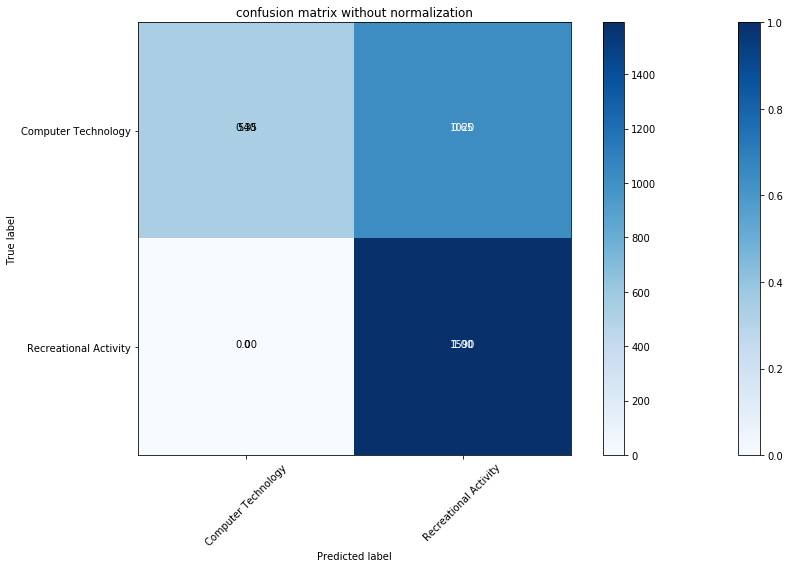

Accuracy: 0.6761904761904762
Recall: 1.0
Precision: 0.6091954022988506
F1-Score: 0.7571428571428572
--- PART B: Cross-Validation ---


C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

Best value of γ =  100  is obtained with cross validation score of  0.8672778089511748

Best SVM ----------------------------
Confusion Matrix: 
Normalized confusion matrix
[[0.96 0.04]
 [0.02 0.98]]
Confusion matrix, without normalization
[[1504   56]
 [  32 1558]]


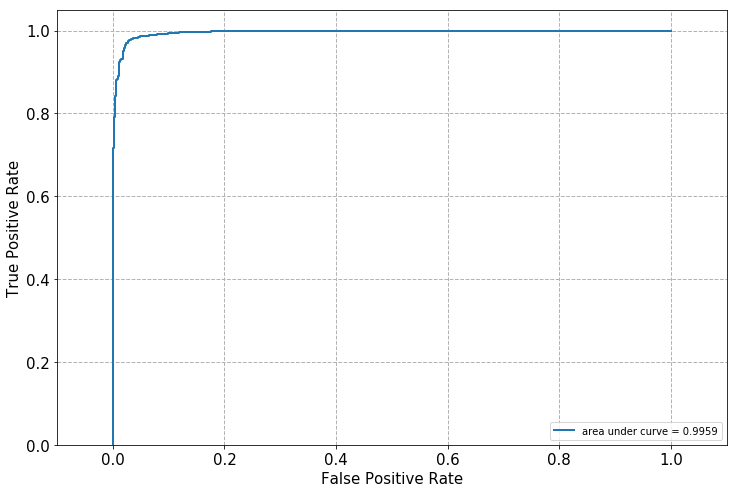

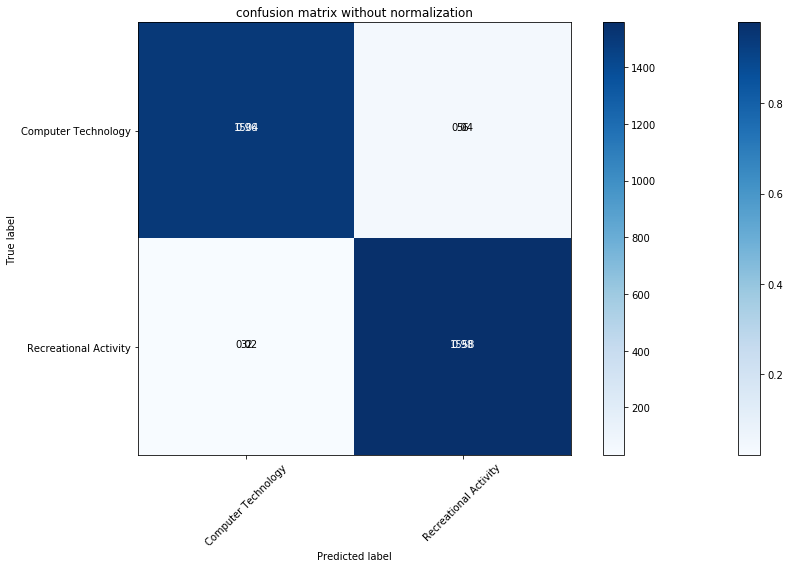

Accuracy: 0.9720634920634921
Recall: 0.979874213836478
Precision: 0.9653035935563816
F1-Score: 0.9725343320848939


In [20]:
# Plot the confusion_matrix, for q4, q5, q6
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Classify the dataset into 2 categories
cat_0 = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
cat_1 = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
classes = ['Computer Technology', 'Recreational Activity']    
def classify(dataset):
    cat = []
    for i in dataset.target:
        if(i < 4):
            cat.append(0)
        else: 
            cat.append(1)
    return(cat)


y_train = classify(train_dataset)    
y_test = classify(test_dataset) 

"""
QUESTION 4
"""
print("----------- QUESTION 4 -----------")           

svm_hard = LinearSVC(C = 1000, random_state = 42)
svm_soft = LinearSVC(C = 0.0001, random_state = 42)

def question4(svm):
    svm.fit(X_train_LSI, y_train)	
    
    # ----------------------
    # ROC Curves
    test_score = svm.decision_function(X_test_LSI)
    fpr, tpr, threshold = roc_curve(y_test, test_score)
    plot_roc(fpr, tpr)
    
    # ----------------------
    # Metrics
    y_test_predict = svm.predict(X_test_LSI)
    
    confusionMatrix = confusion_matrix(y_test, y_test_predict)
    accuracy = accuracy_score(y_test, y_test_predict)
    recall = recall_score(y_test, y_test_predict)
    precision = precision_score(y_test, y_test_predict)
    f1_score = 2/((1/recall) + (1/precision))
    
    print('Confusion Matrix: ')
    plt.figure()
    plot_confusion_matrix(confusionMatrix, classes=classes, normalize=True, title='Normalized confusion matrix')
    plot_confusion_matrix(confusionMatrix, classes=classes,title='confusion matrix without normalization')
    plt.show()
    print('Accuracy:', accuracy)
    print('Recall:', recall)
    print('Precision:', precision)
    print('F1-Score:', f1_score)


print('\nHard Margin ----------------------------')
question4(svm_hard)
print('\nSoft Margin ----------------------------')
question4(svm_soft)

print("--- PART B: Cross-Validation ---")
C_best = 0;
max_score = 0;

for i in range(-3, 4): 
    C = 10**i;
    clf = LinearSVC(C = C,random_state=42);
    scores = cross_val_score(clf, X_train_LSI, train_dataset.target, cv=5).mean()
    #print('Mean score: ', scores)
    
    if(scores > max_score):
        max_score = scores
        C_best = C
    
print('Best value of \u03B3 = ', C_best, ' is obtained with cross validation score of ', max_score)
svm_best = LinearSVC(C = C_best,random_state=42)
print('\nBest SVM ----------------------------')
question4(svm_best)

----------- QUESTION 5 -----------
--------ROC curve and scores without regularization--------


C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Confusion Matrix: 
Confusion matrix, without normalization
[[1502   58]
 [  33 1557]]


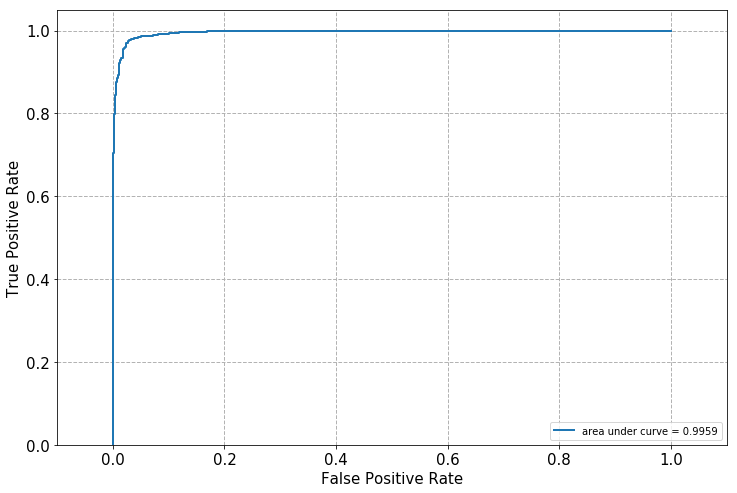

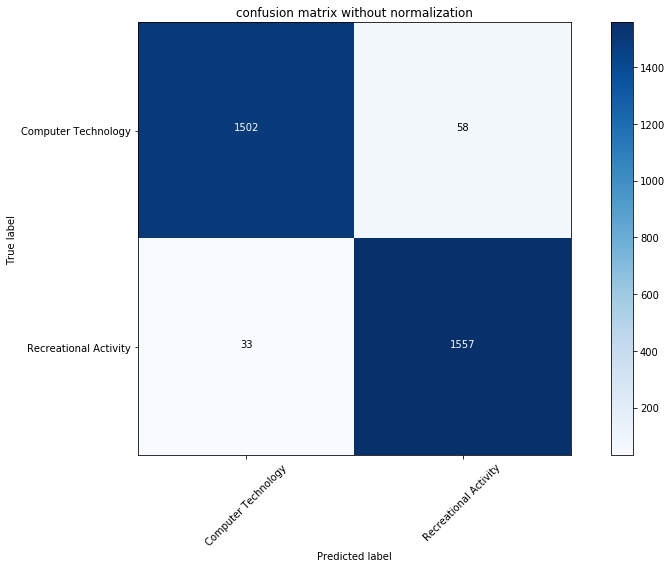

Accuracy: 0.9711111111111111
Recall: 0.9792452830188679
Precision: 0.9640866873065016
F1: 0.9716068642745709
--------find the best k for L1 regularization--------


C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be

C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

the score list is  [0.33485689985281036, 0.8887268757299228, 0.9564255566832308, 0.9659428229680949, 0.9720793642214719, 0.9712329692683621, 0.9712331560782627]
the best k for L1 regularization is  1





--------find the best k for L2 regularization--------


C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

the score list is  [0.596931159133188, 0.9092450204075643, 0.9608798698861154, 0.967005452562705, 0.9720791600309994, 0.9720788770507994, 0.9714445080221648]
the best k for L1 regularization is  1





--------ROC curve and scores for L1 regularization with k=1--------
Confusion Matrix: 
Confusion matrix, without normalization
[[1500   60]
 [  32 1558]]


C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


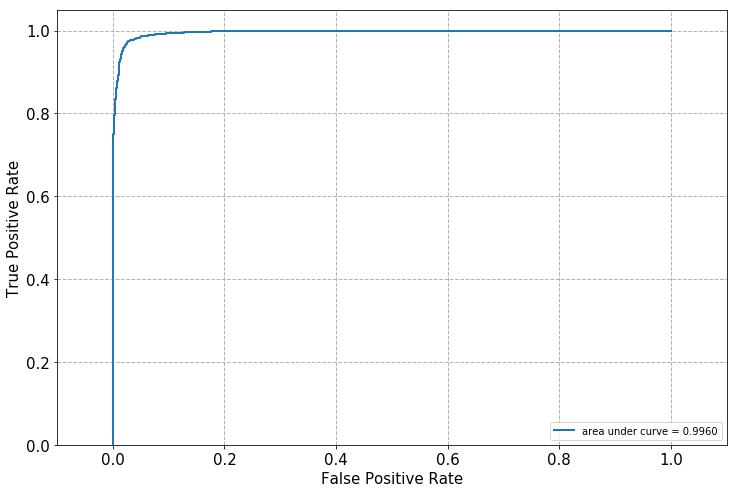

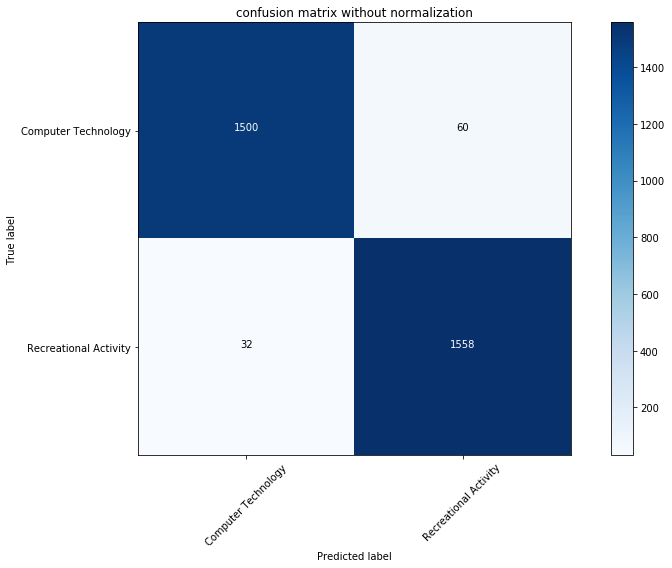

Accuracy: 0.9707936507936508
Recall: 0.979874213836478
Precision: 0.9629171817058096
F1: 0.9713216957605986





--------ROC curve and scores for L2 regularization with k=1--------
Confusion Matrix: 
Confusion matrix, without normalization
[[1500   60]
 [  28 1562]]


C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


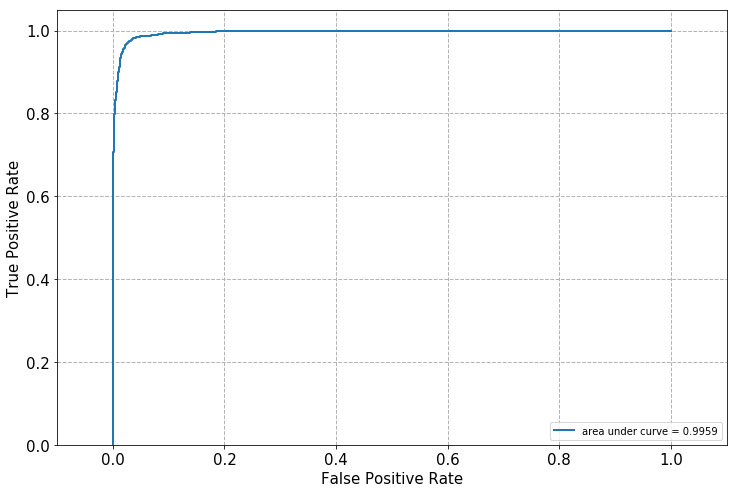

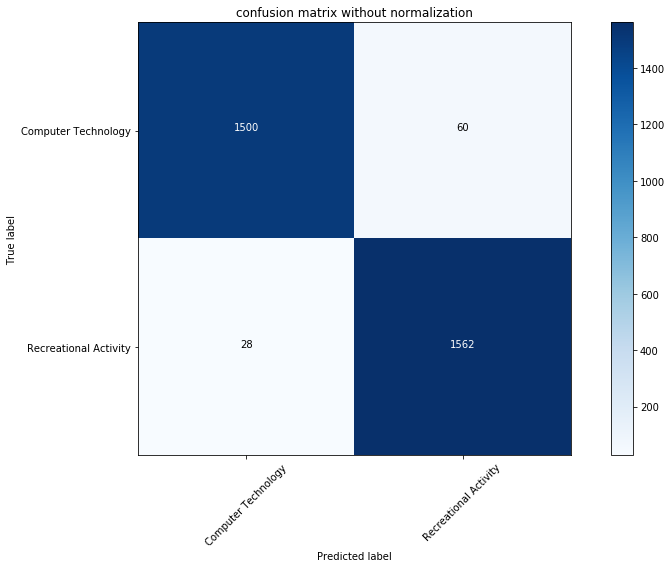

Accuracy: 0.9720634920634921
Recall: 0.9823899371069182
Precision: 0.9630086313193588
F1: 0.9726027397260274


In [21]:
"""
QUESTION 5
"""
print("----------- QUESTION 5 -----------")
def logistic_train_plot_score(clf):
    # train a model
    clf.fit(X_train_LSI,y_train)
    
    # plot ROC curve
    test_score = clf.decision_function(X_test_LSI)
    fpr, tpr, threshold = roc_curve(y_test, test_score)
    plot_roc(fpr, tpr)   
    
    # calculate scores
    y_test_predict = clf.predict(X_test_LSI)
    
    confusionMatrix = confusion_matrix(y_test, y_test_predict)
    accuracy = accuracy_score(y_test, y_test_predict)
    recall = recall_score(y_test, y_test_predict)
    precision = precision_score(y_test, y_test_predict)
    f1_score = 2/((1/recall) + (1/precision))   
    print('Confusion Matrix: ')
    plt.figure()
    plot_confusion_matrix(confusionMatrix, classes=classes, title='confusion matrix without normalization')
    #plot_confusion_matrix(confusionMatrix, classes=classes, normalize=True,title='normalized confusion matrix')
    plt.show()
    print('Accuracy:', accuracy)
    print('Recall:', recall)
    print('Precision:', precision)
    print('F1:', f1_score)

# ROC curve and scores for logistic regression without regularization
print("--------ROC curve and scores without regularization--------")
clf_logistic = LogisticRegression(C=10**8,random_state=42)
logistic_train_plot_score(clf_logistic)

# 5-fold cross validation to find the best C for L1 regularization and L2 regularization
def score_with_k(pen):
    score_list = []
    k_list = range(-3,4)
    for k in k_list:
        clf = LogisticRegression(penalty=pen, C=10**k, random_state=42)
        cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
        scores = cross_val_score(clf, X_train_LSI, y_train, cv=cv, scoring='f1_macro')
        avg_score = np.average(scores)
        score_list.append(avg_score)
    print("the score list is ",score_list)
    best_k_loc = np.argmax(score_list)
    best_k = k_list[best_k_loc]
    return best_k

# best k for L1-regularization 
print("--------find the best k for L1 regularization--------")
best_k_L1 = score_with_k('l1')
print("the best k for L1 regularization is ",best_k_L1)
print('\n\n\n\n')

# best k for L2-regularization
print("--------find the best k for L2 regularization--------")
best_k_L2 = score_with_k('l2')
print("the best k for L1 regularization is ",best_k_L2)
print('\n\n\n\n')
    
    
# ROC curve and scores for logistic regression with L1 regularization
print("--------ROC curve and scores for L1 regularization with k=1--------")
clf_logistic_L1 = LogisticRegression(penalty='l1',C=10**best_k_L1, random_state=42)
logistic_train_plot_score(clf_logistic_L1)
print('\n\n\n\n')

# ROC curve and scores for logistic regression with L2 regularization
print("--------ROC curve and scores for L2 regularization with k=1--------")
clf_logistic_L2 = LogisticRegression(penalty='l2',C=10**best_k_L2, random_state=42)
logistic_train_plot_score(clf_logistic_L2)

----------- QUESTION 6 -----------
Normalized confusion matrix
[[0.86 0.14]
 [0.04 0.96]]


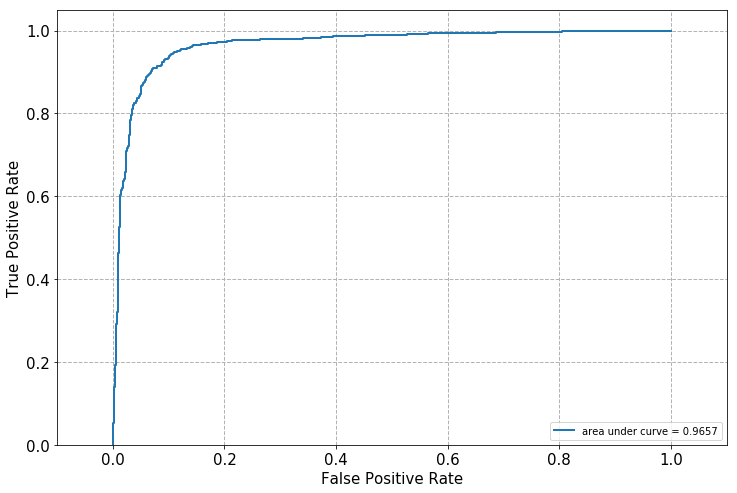

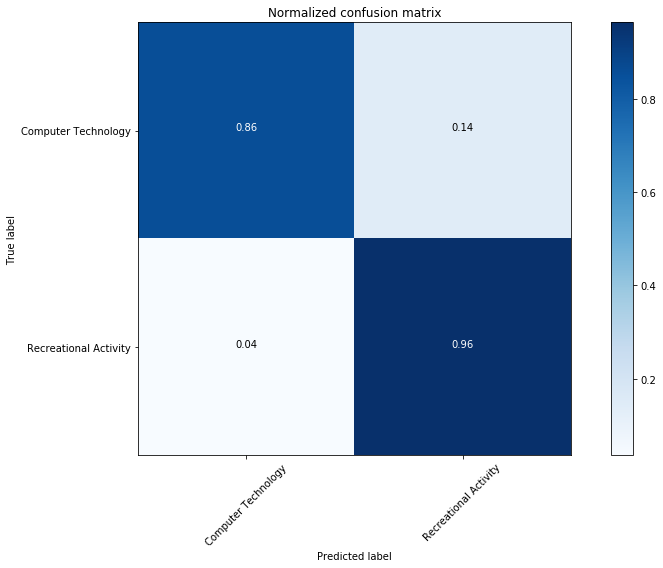

Accuracy:  0.9107936507936508
Recall:  0.9107936507936508
Precision:  0.9152716180673172
F1:  0.9152716180673172







In [22]:
"""
QUESTION 6
"""
print("----------- QUESTION 6 -----------")

# plot ROC curve
classifierNB_score = GaussianNB().fit(X_train_LSI, y_train).predict_proba(X_test_LSI)
fpr, tpr, _ = roc_curve(y_test, classifierNB_score[:,1])
plot_roc(fpr, tpr)

# Classify by Gaussian Naive Bayes 
classifierNB = GaussianNB().fit(X_train_LSI, y_train).predict(X_test_LSI)

# Compute confusion matrix
cnf_matrix_NB = confusion_matrix(y_test, classifierNB)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_NB, classes=classes, normalize=True, title='Normalized confusion matrix')
plt.show()

# Calculate 4 scores 
accuracy_NB = accuracy_score(y_test, classifierNB)
print("Accuracy: ", accuracy_NB)
recall_NB = recall_score(y_test, classifierNB, average='weighted')
print("Recall: ",recall_NB)
precision_NB = precision_score(y_test, classifierNB, average='weighted')
print("Precision: ",precision_NB)
f1_NB = f1_score(y_test, classifierNB, average='weighted')
print("F1: ",precision_NB)
print('\n\n\n\n')

In [6]:
"""
QUESTION 7
"""

print("----------- QUESTION 7 -----------")
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import pandas as pd
# used to cache results
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory
# print(__doc__)
cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

pipeline = Pipeline([
    ('vect', text.CountVectorizer(stop_words='english')),
    ('tfidf', text.TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=42)),
    ('clf', GaussianNB()),
],
memory=memory
)

param_grid = [{
        'vect__min_df': [3,5],
        'vect__analyzer': [stem_rmv_punc, 'word'],
        'reduce_dim': [TruncatedSVD(), NMF()],
    }
    { 
        'vect__min_df': [3,5],
        'vect__analyzer': [stem_rmv_punc, 'word'],
        'reduce_dim': [TruncatedSVD(), NMF()],
        'clf': [LinearSVC()],
        'clf__C': [100],    
   },
   {
        'vect__min_df': [3,5],
        'vect__analyzer': [stem_rmv_punc, 'word'],
        'reduce_dim': [TruncatedSVD(), NMF()],
        'clf': [LogisticRegression()],
        'clf__penalty': ['l2', 'L1'],
        'clf__C': [10],   
   }, 
]

grid = GridSearchCV(pipeline, cv=5, n_jobs=1, param_grid=param_grid, scoring='accuracy')
grid.fit(train_dataset.data[0:50], y_train[0:50])
pd.DataFrame(grid.cv_results_)
print('done part 1')

rmtree(cachedir)

train_dataset_remove = fetch_20newsgroups(subset = 'train', categories = categories, remove=('headers', 'footers', 'quotes'),
                                   shuffle = True, random_state = 42)

pipeline = Pipeline([
    ('vect', text.CountVectorizer(stop_words='english')),
    ('tfidf', text.TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(n_components=50, random_state=42)),
    ('clf', GaussianNB()),
],
)

gridR = GridSearchCV(pipeline, cv=5, n_jobs=2, param_grid=param_grid, scoring='accuracy')
gridR.fit(train_dataset_remove.data[0:50], y_train[0:50])
pd.DataFrame(gridR.cv_results_)
print('Finished!')
                                    

----------- QUESTION 7 -----------
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function stem_rmv_punc at 0x0000019AD12B49D8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=3, ngram_range=(1, 1), preprocessor=None,
        stop_words='english', strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None), 
[ 'From: kristyn@netcom.com (Kristyn Geenwood)\n'
  'Subject: Re: Boom! Dog attack!\n'
  'Organization: Netcom - Online Communication Services (408 241-9760 guest)\n'
  'Lines: 32\n'
  '\n'
  '\n'
  'In article <9426.97.uupcb@compdyn.questor.org> '
  'ryan_cousineau@compdyn.questor.org (Ryan Cousineau)  writes:\n'
  '>My previous posting on dog attacks must have generated some bad kar

C:\Users\andyx\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='C:\\Users\\andyx\\AppData\\Local\\Temp\\tmp2405r6md'", use "location='C:\\Users\\andyx\\AppData\\Local\\Temp\\tmp2405r6md'" instead.
  from ipykernel import kernelapp as app


________________________________________________fit_transform_one - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <39x210 sparse matrix of type '<class 'numpy.int64'>'
	with 1130 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  0], 
None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=None, tol=0.0), 
<39x210 sparse matrix of ty

________________________________________________fit_transform_one - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <40x249 sparse matrix of type '<class 'numpy.int64'>'
	with 1267 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  0], 
None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=None, tol=0.0), 
<40x249 sparse matrix 

________________________________________________fit_transform_one - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <40x62 sparse matrix of type '<class 'numpy.int64'>'
	with 607 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  0], 
None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=None, tol=0.0), 
<40x62 sparse matrix of 

________________________________________________fit_transform_one - 0.4s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <41x72 sparse matrix of type '<class 'numpy.int64'>'
	with 663 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  1], 
None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=None, tol=0.0), 
<41x72 sparse matri

________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <40x259 sparse matrix of type '<class 'numpy.int64'>'
	with 1251 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  0], 
None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=None, tol=0.0), 
<40x259 sparse matrix 

________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <40x73 sparse matrix of type '<class 'numpy.int64'>'
	with 645 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  0], 
None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=None, tol=0.0), 
<40x73 sparse matrix of 

________________________________________________fit_transform_one - 0.5s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\andyx\AppData\Local\Temp\tmp2405r6md\joblib\sklearn\pipeline\_fit_transform_one\84784f62e3ef0025fd38291fcbd51092
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\andyx\AppData\Local\Temp\tmp2405r6md\joblib\sklearn\pipeline\_fit_transform_one\0732bfb8b446a9cd91e4dcb558a92c6a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=None, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0), 
<40x222 sparse matrix of type '<class 'numpy.float64'>'
	with 1138 st

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\andyx\AppData\Local\Temp\tmp2405r6md\joblib\sklearn\pipeline\_fit_transform_one\73f454cf49f8ca2f76f74efc8506625e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\andyx\AppData\Local\Temp\tmp2405r6md\joblib\sklearn\pipeline\_fit_transform_one\85a2335c20d321128507cd3889d732aa
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=None, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0), 
<40x75 sparse matrix of type '<class 'numpy.float64'>'
	with 695 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0,

________________________________________________fit_transform_one - 0.3s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\andyx\AppData\Local\Temp\tmp2405r6md\joblib\sklearn\pipeline\_fit_transform_one\71a9521b101f71a30b39aa9406af358e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\andyx\AppData\Local\Temp\tmp2405r6md\joblib\sklearn\pipeline\_fit_transform_one\10f1a7fe4bb038cff17aad6a4322f561
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=None, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0), 
<39x72 sparse matrix of type '<class 'numpy.float64'>'
	with 634 stor

C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


________________________________________________fit_transform_one - 0.5s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <50x316 sparse matrix of type '<class 'numpy.int64'>'
	with 1676 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  0,
  0], 
None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=

C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\util

Finished!


C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\utils\deprecation

Shape of TF-IDF train matrices subset: 
(2352, 8396)
Shape of TF-IDF test matrices subset: 
(1565, 8396)
Multiclass SVM one vs one (with LSI): 


C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

Confusion matrix, without normalization
[[325  44  23   0]
 [ 35 324  26   0]
 [ 23  18 346   3]
 [  4   1   3 390]]
Normalized confusion matrix
[[0.83 0.11 0.06 0.  ]
 [0.09 0.84 0.07 0.  ]
 [0.06 0.05 0.89 0.01]
 [0.01 0.   0.01 0.98]]


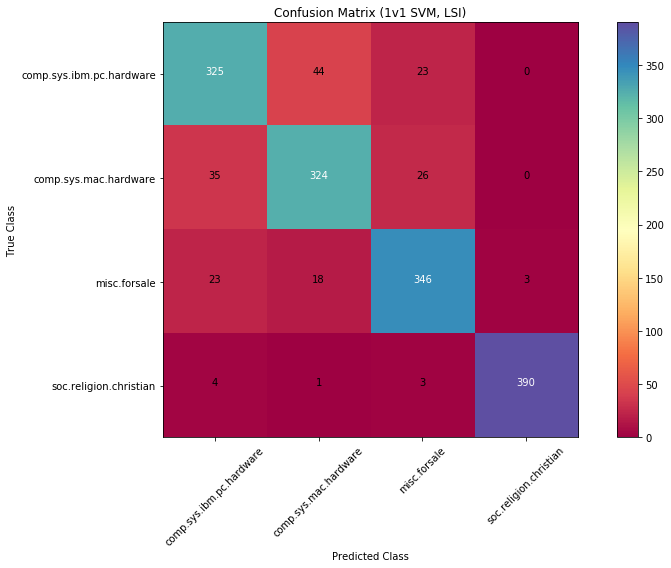

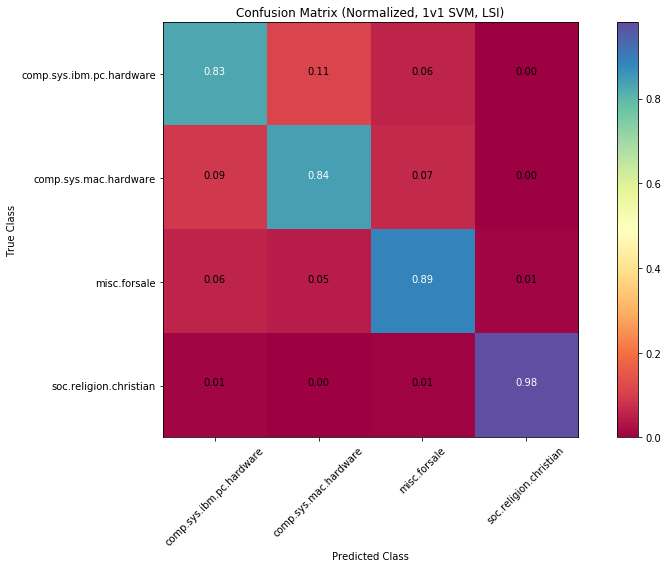

Accuracy:   0.8849840255591054
Recall:     0.8849840255591054
Precision:  0.8853237099011754
F-1:  0.8853237099011754
Multiclass SVM one vs one (with NMF): 


C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

Confusion matrix, without normalization
[[305  64  23   0]
 [ 92 273  19   1]
 [ 46  17 325   2]
 [ 11   3   3 381]]
Normalized confusion matrix
[[0.78 0.16 0.06 0.  ]
 [0.24 0.71 0.05 0.  ]
 [0.12 0.04 0.83 0.01]
 [0.03 0.01 0.01 0.96]]


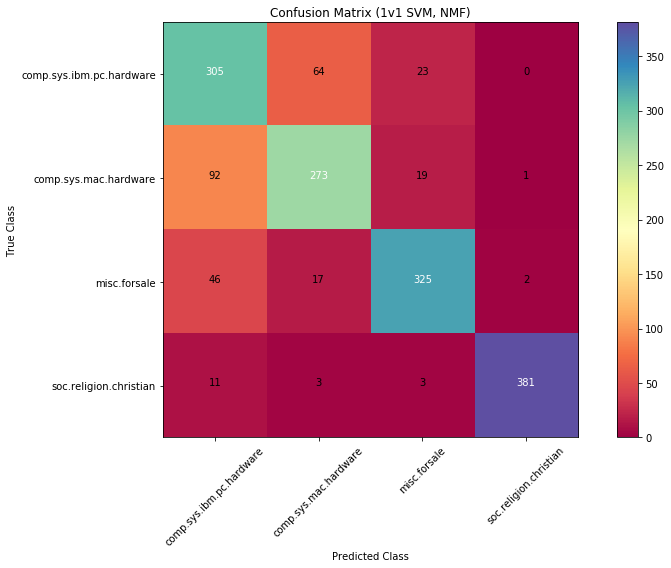

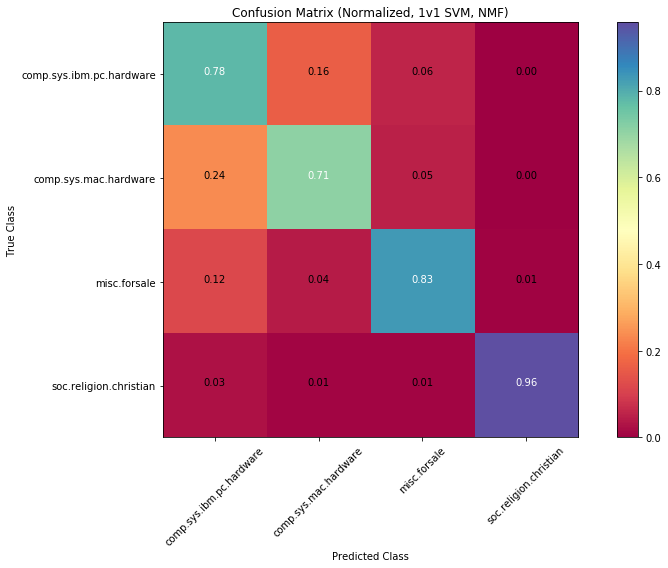

Accuracy:   0.8204472843450479
Recall:     0.8204472843450479
Precision:  0.8276153194214666
F-1:  0.8276153194214666
Multiclass SVM one vs the rest (with LSI): 


C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

Confusion matrix, without normalization
[[311  52  29   0]
 [ 32 328  23   2]
 [ 20  18 350   2]
 [  5   1   2 390]]
Normalized confusion matrix
[[0.79 0.13 0.07 0.  ]
 [0.08 0.85 0.06 0.01]
 [0.05 0.05 0.9  0.01]
 [0.01 0.   0.01 0.98]]


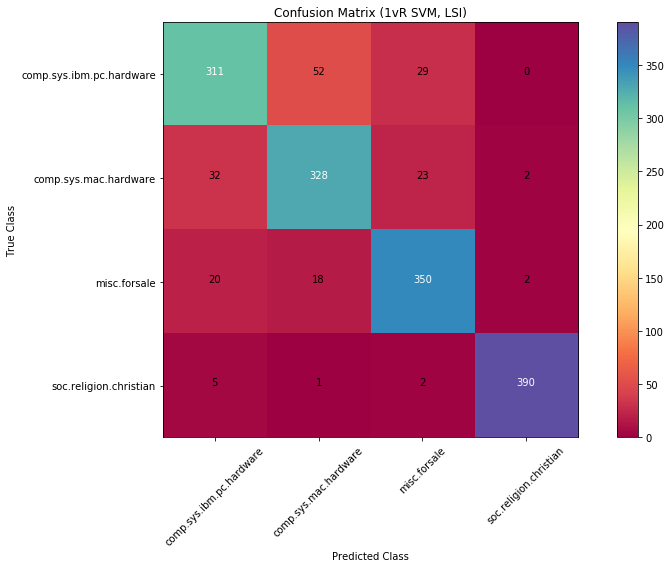

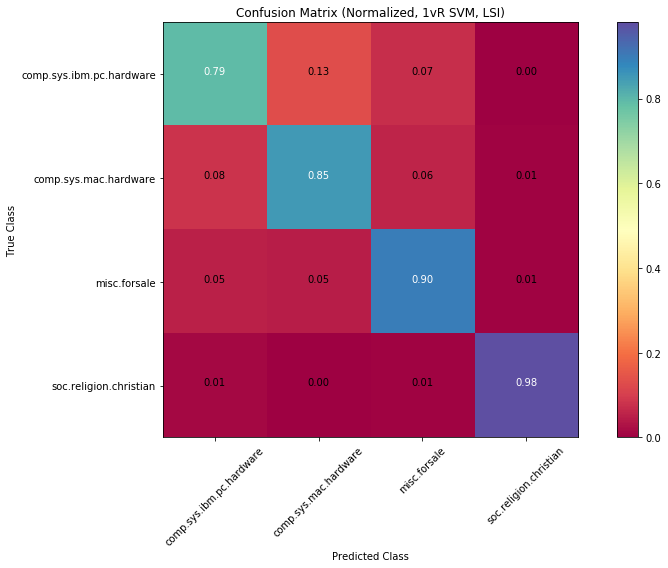

Accuracy:   0.8811501597444089
Recall:     0.8811501597444089
Precision:  0.8815364311549422
F-1:  0.8815364311549422
Multiclass SVM one vs the rest (with NMF): 


C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\andyx\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarni

Confusion matrix, without normalization
[[287  64  38   3]
 [ 64 285  28   8]
 [ 29  16 342   3]
 [  5   2   1 390]]
Normalized confusion matrix
[[0.73 0.16 0.1  0.01]
 [0.17 0.74 0.07 0.02]
 [0.07 0.04 0.88 0.01]
 [0.01 0.01 0.   0.98]]


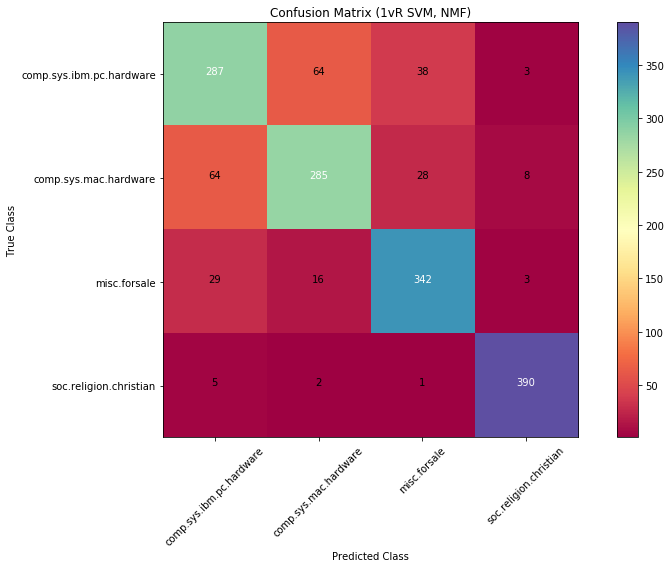

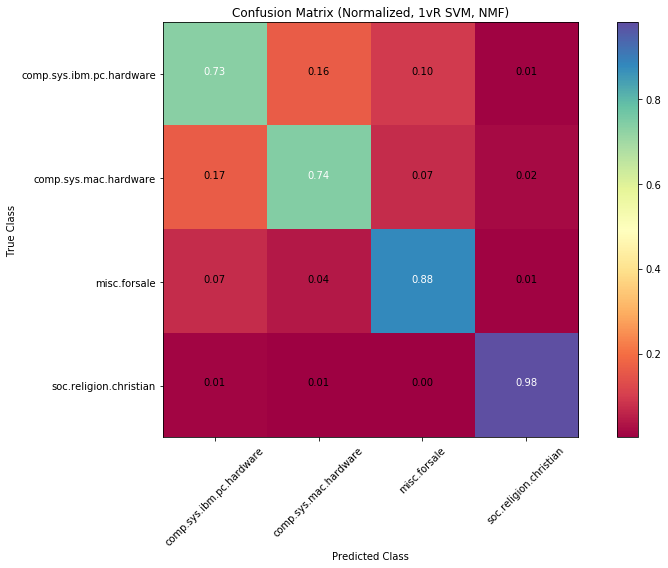

Accuracy:   0.8332268370607029
Recall:     0.8332268370607029
Precision:  0.8316401109794194
F-1:  0.8316401109794194
Multiclass Naive Bayes (with LSI): 
Confusion matrix, without normalization
[[237  41 110   4]
 [ 99 167 115   4]
 [ 47  46 294   3]
 [  0   0  17 381]]
Normalized confusion matrix
[[0.6  0.1  0.28 0.01]
 [0.26 0.43 0.3  0.01]
 [0.12 0.12 0.75 0.01]
 [0.   0.   0.04 0.96]]


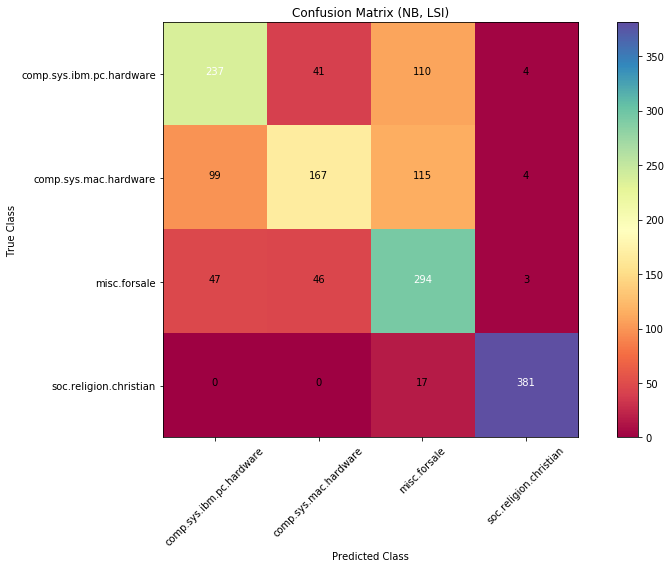

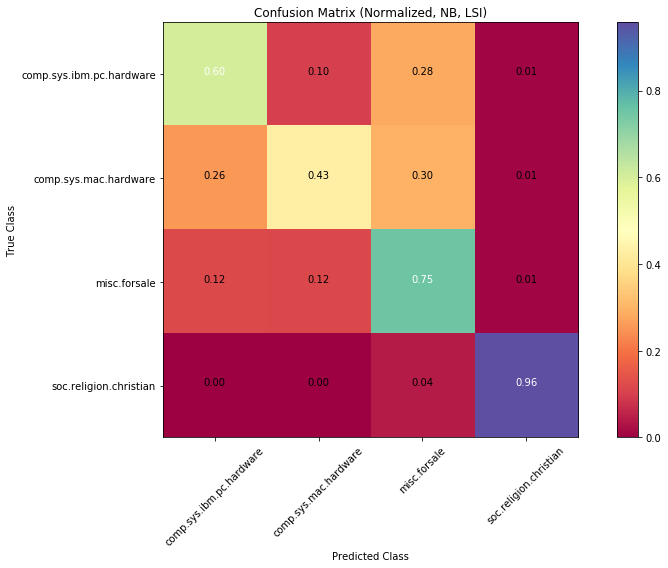

Accuracy:   0.6894568690095847
Recall:     0.6894568690095847
Precision:  0.700606169304273
F-1:  0.700606169304273
Multiclass Naive Bayes (with NMF): 
Confusion matrix, without normalization
[[295  36  54   7]
 [116 197  68   4]
 [ 76  27 270  17]
 [  3   1   4 390]]
Normalized confusion matrix
[[0.75 0.09 0.14 0.02]
 [0.3  0.51 0.18 0.01]
 [0.19 0.07 0.69 0.04]
 [0.01 0.   0.01 0.98]]


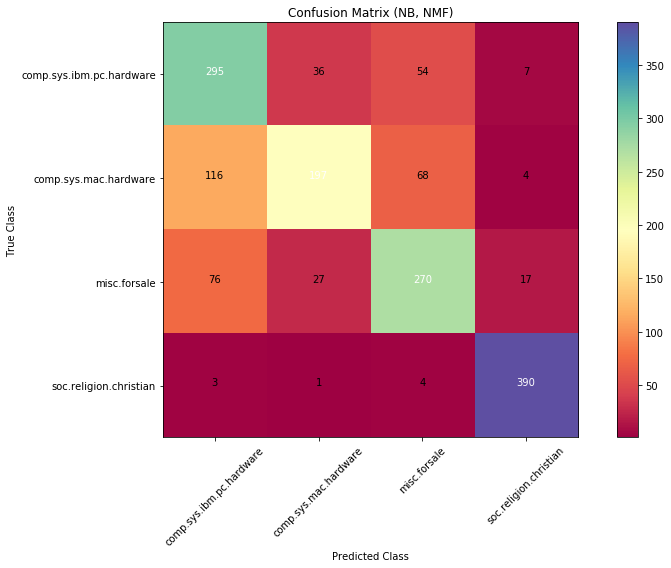

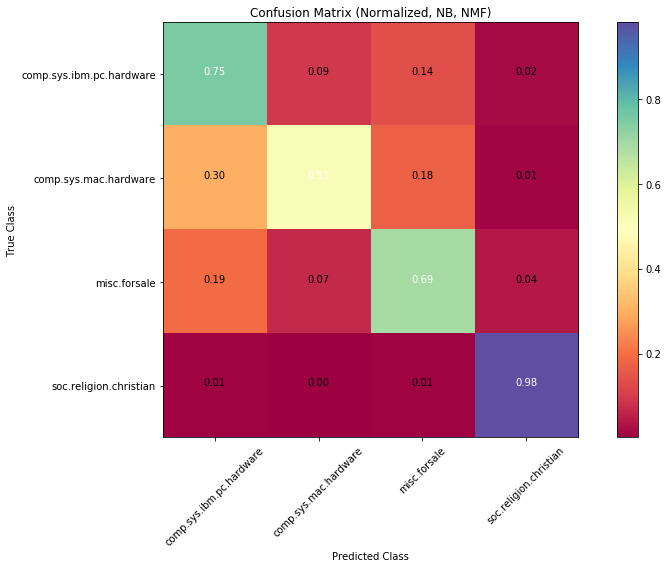

Accuracy:   0.7361022364217252
Recall:     0.7361022364217252
Precision:  0.7436694399741546
F-1:  0.7436694399741546


In [14]:
# Q8 Multiclass Classification

# import data and generate LSI-reduced TF-IDF matrix
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction import text
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import stopwords
from string import punctuation
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]  #set image size for display

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

categories = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'misc.forsale', 'soc.religion.christian']
train_dataset = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
test_dataset = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

stop_words_skt = text.ENGLISH_STOP_WORDS
stop_words_en = stopwords.words('english')
combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))

def penn2morphy(penntag):
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

ps = nltk.stem.PorterStemmer()
wnl = nltk.wordnet.WordNetLemmatizer()     

def lemmatize_sent(list_word):
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) for word, tag in pos_tag(list_word)]

def stem_rmv_punc(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if word not in combined_stopwords and not word.isdigit())

analyzer = text.CountVectorizer().build_analyzer()
vectorizer = text.CountVectorizer(min_df=3, stop_words='english', analyzer=stem_rmv_punc, token_pattern = r'(?u)\b[A-Za-z][A-Za-z]+\b')

X_train_counts = vectorizer.fit_transform(train_dataset.data)
X_train_counts.toarray()
X_test_counts = vectorizer.transform(test_dataset.data)
X_test_counts.toarray()
X_train_tfidf = text.TfidfTransformer().fit_transform(X_train_counts)
print('Shape of TF-IDF train matrices subset: ')
print(X_train_tfidf.shape)
X_test_tfidf = text.TfidfTransformer().fit_transform(X_test_counts)
print('Shape of TF-IDF test matrices subset: ')
print(X_test_tfidf.shape)

#LSI: 
from sklearn.decomposition import TruncatedSVD
lsi = TruncatedSVD(n_components=50, random_state=42) 
X_train_LSI = lsi.fit_transform(X_train_tfidf)
X_test_LSI = lsi.transform(X_test_tfidf)

#NMF:
from sklearn.decomposition import NMF
nmf = NMF(n_components=50, random_state=42)
X_train_NMF = nmf.fit_transform(X_train_tfidf)
X_test_NMF = nmf.transform(X_test_tfidf)

X_train_target = train_dataset.target
X_test_target = test_dataset.target

# For plotting confusion matrix and compute metrics: 
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Spectral):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.tight_layout()
    
 # Multiclass SVM (one vs. one)

from sklearn import svm
from sklearn.multiclass import OneVsOneClassifier

print("Multiclass SVM one vs one (with LSI): ")

clf_1v1 = OneVsOneClassifier(svm.SVC(C=1000)).fit(X_train_LSI, X_train_target)
X_predict_1v1 = clf_1v1.predict(X_test_LSI)

cf_mat = confusion_matrix(X_test_target, X_predict_1v1)
np.set_printoptions(precision=2)

#Plot confusion matrices -- unnormalized and normalized
plt.figure()
plot_confusion_matrix(cf_mat, classes=categories,
                      title='Confusion Matrix (1v1 SVM, LSI)')
plt.figure()
plot_confusion_matrix(cf_mat, classes=categories, normalize=True,
                      title='Confusion Matrix (Normalized, 1v1 SVM, LSI)')
plt.show()

# Compute Metrics: 
accuracy = accuracy_score(X_test_target, X_predict_1v1)
recall = recall_score(X_test_target, X_predict_1v1, average='weighted')
precision = precision_score(X_test_target, X_predict_1v1, average='weighted')
F1 = f1_score(X_test_target, X_predict_1v1, average='weighted')

print("Accuracy:  ", accuracy)
print("Recall:    ",recall)
print("Precision: ",precision)
print("F-1: ",precision)

print("Multiclass SVM one vs one (with NMF): ")

clf_1v1 = OneVsOneClassifier(svm.SVC(C=1000)).fit(X_train_NMF, X_train_target)
X_predict_1v1 = clf_1v1.predict(X_test_NMF)

cf_mat = confusion_matrix(X_test_target, X_predict_1v1)
np.set_printoptions(precision=2)

#Plot confusion matrices -- unnormalized and normalized
plt.figure()
plot_confusion_matrix(cf_mat, classes=categories,
                      title='Confusion Matrix (1v1 SVM, NMF)')
plt.figure()
plot_confusion_matrix(cf_mat, classes=categories, normalize=True,
                      title='Confusion Matrix (Normalized, 1v1 SVM, NMF)')
plt.show()

# Compute Metrics: 
accuracy = accuracy_score(X_test_target, X_predict_1v1)
recall = recall_score(X_test_target, X_predict_1v1, average='weighted')
precision = precision_score(X_test_target, X_predict_1v1, average='weighted')
F1 = f1_score(X_test_target, X_predict_1v1, average='weighted')

print("Accuracy:  ",accuracy)
print("Recall:    ",recall)
print("Precision: ",precision)
print("F-1: ",precision)

# Multiclass SVM (one vs. the rest)

from sklearn.multiclass import OneVsRestClassifier

print("Multiclass SVM one vs the rest (with LSI): ")

clf_1vR = OneVsRestClassifier(svm.SVC(C=1000)).fit(X_train_LSI, X_train_target)
X_predict_1vR = clf_1vR.predict(X_test_LSI)

cf_mat = confusion_matrix(X_test_target, X_predict_1vR)
np.set_printoptions(precision=2)

#Plot confusion matrices -- unnormalized and normalized
plt.figure()
plot_confusion_matrix(cf_mat, classes=categories,
                      title='Confusion Matrix (1vR SVM, LSI)')
plt.figure()
plot_confusion_matrix(cf_mat, classes=categories, normalize=True,
                      title='Confusion Matrix (Normalized, 1vR SVM, LSI)')
plt.show()

# Compute Metrics: 
accuracy = accuracy_score(X_test_target, X_predict_1vR)
recall = recall_score(X_test_target, X_predict_1vR, average='weighted')
precision = precision_score(X_test_target, X_predict_1vR, average='weighted')
F1 = f1_score(X_test_target, X_predict_1vR, average='weighted')

print("Accuracy:  ", accuracy)
print("Recall:    ",recall)
print("Precision: ",precision)
print("F-1: ",precision)

print("Multiclass SVM one vs the rest (with NMF): ")

clf_1vR = OneVsRestClassifier(svm.SVC(C=1000)).fit(X_train_NMF, X_train_target)
X_predict_1vR = clf_1vR.predict(X_test_NMF)

cf_mat = confusion_matrix(X_test_target, X_predict_1vR)
np.set_printoptions(precision=2)

#Plot confusion matrices -- unnormalized and normalized
plt.figure()
plot_confusion_matrix(cf_mat, classes=categories,
                      title='Confusion Matrix (1vR SVM, NMF)')
plt.figure()
plot_confusion_matrix(cf_mat, classes=categories, normalize=True,
                      title='Confusion Matrix (Normalized, 1vR SVM, NMF)')
plt.show()

# Compute Metrics: 
accuracy = accuracy_score(X_test_target, X_predict_1vR)
recall = recall_score(X_test_target, X_predict_1vR, average='weighted')
precision = precision_score(X_test_target, X_predict_1vR, average='weighted')
F1 = f1_score(X_test_target, X_predict_1vR, average='weighted')

print("Accuracy:  ", accuracy)
print("Recall:    ",recall)
print("Precision: ",precision)
print("F-1: ",precision)

# Multiclass Naive Bayes with LSI

from sklearn.naive_bayes import GaussianNB
print("Multiclass Naive Bayes (with LSI): ")

gnb = GaussianNB()
gnb.fit(X_train_LSI, X_train_target)
X_predict_NB = gnb.predict(X_test_LSI)

cf_mat = confusion_matrix(X_test_target, X_predict_NB)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cf_mat, classes=categories,
                      title='Confusion Matrix (NB, LSI)')

plt.figure()
plot_confusion_matrix(cf_mat, classes=categories, normalize=True,
                      title='Confusion Matrix (Normalized, NB, LSI)')

plt.show()

# Compute Metrics: 
accuracy = accuracy_score(X_test_target, X_predict_NB)
recall = recall_score(X_test_target, X_predict_NB, average='weighted')
precision = precision_score(X_test_target, X_predict_NB, average='weighted')
F1 = f1_score(X_test_target, X_predict_NB, average='weighted')

print("Accuracy:  ", accuracy)
print("Recall:    ",recall)
print("Precision: ",precision)
print("F-1: ",precision)

# Multiclass Naive Bayes with NMF

from sklearn.naive_bayes import GaussianNB
print("Multiclass Naive Bayes (with NMF): ")

gnb = GaussianNB()
gnb.fit(X_train_NMF, X_train_target)
X_predict_NB = gnb.predict(X_test_NMF)

cf_mat = confusion_matrix(X_test_target, X_predict_NB)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cf_mat, classes=categories,
                      title='Confusion Matrix (NB, NMF)')

plt.figure()
plot_confusion_matrix(cf_mat, classes=categories, normalize=True,
                      title='Confusion Matrix (Normalized, NB, NMF)')

plt.show()

# Compute Metrics: 
accuracy = accuracy_score(X_test_target, X_predict_NB)
recall = recall_score(X_test_target, X_predict_NB, average='weighted')
precision = precision_score(X_test_target, X_predict_NB, average='weighted')
F1 = f1_score(X_test_target, X_predict_NB, average='weighted')

print("Accuracy:  ", accuracy)
print("Recall:    ",recall)
print("Precision: ",precision)
print("F-1: ",precision)



In [13]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 
pd.set_option('max_colwidth',100)
print(pd.DataFrame(grid.cv_results_))
print(pd.DataFrame(gridR.cv_results_))     

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.615432      0.049190         0.137230        0.019139   
1       0.607811      0.047928         0.140353        0.021637   
2       0.098944      0.002605         0.001304        0.002608   
3       0.081503      0.011684         0.003125        0.006250   
4       1.219066      1.420225         0.214289        0.090181   
5       0.093010      0.026415         0.131173        0.031452   
6       0.591346      0.268152         0.047676        0.008286   
7       0.072625      0.014113         0.009374        0.007654   

                                                                                      param_reduce_dim  \
0   TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,\n       random_state=None, tol=0.0)   
1   TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,\n       random_state=None, tol=0.0)   
2   TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,\n       ran